In [1]:
# install dependencies: 
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8MB 26kB/s 
     |████████████████████████████████| 6.6MB 22.3MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.5.0+cu101 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
     |████████████████████████████████| 276kB 8.5MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44074 sha256=2ef8f4cf6cec8a022c5ad1c1730792c3a895323d07f0a7119cb0c40da464ce3b
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.1

In [2]:
!nvidia-smi

Mon May 10 11:10:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!cp /content/drive/MyDrive/dal_publaynet.zip /content

In [4]:
!unzip /content/dal_publaynet.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: train/PMC5276858_00014.jpg  
  inflating: train/PMC4377480_00001.jpg  
  inflating: train/PMC4189985_00001.jpg  
  inflating: train/PMC3745965_00001.jpg  
  inflating: train/PMC3582095_00002.jpg  
  inflating: train/PMC3087892_00001.jpg  
  inflating: train/PMC3235901_00003.jpg  
  inflating: train/PMC3376773_00003.jpg  
  inflating: train/PMC2952911_00003.jpg  
  inflating: train/PMC3649443_00003.jpg  
  inflating: train/PMC3981058_00003.jpg  
  inflating: train/PMC3504410_00001.jpg  
  inflating: train/PMC3316988_00007.jpg  
  inflating: train/PMC3791796_00001.jpg  
  inflating: train/PMC3791796_00003.jpg  
  inflating: train/PMC3876589_00004.jpg  
  inflating: train/PMC4662971_00004.jpg  
  inflating: train/PMC5002484_00004.jpg  
  inflating: train/PMC3512323_00004.jpg  
  inflating: train/PMC3423936_00003.jpg  
  inflating: train/PMC3922004_00002.jpg  
  inflating: train/PMC2946592_00001.jpg  
  inflating: train/

In [5]:
!cp /content/train.json /content/train
!cp /content/test.json /content/test
!cp /content/val.json /content/val

In [6]:
#You may need to restart your runtime prior to this, to let your installation take effect
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [7]:
import json
from detectron2.structures import BoxMode
def get_board_dicts(imgdir,js_file):
    json_file = imgdir+"/" + js_file #Fetch the json file
    with open(json_file) as f:
        dataset_dicts = json.load(f)
        # print(dataset_dicts)
    for i in dataset_dicts:
        filename = i["file_name"] 
        i["file_name"] = imgdir+"/"+filename
        i["image_id"] = i["id"] 
        for j in i["annotations"]:
            j["bbox_mode"] = BoxMode.XYWH_ABS #Setting the required Box Mode
            j["category_id"] = int(j["category_id"]) - 1
    return dataset_dicts
# get_board_dicts("/content/train","train.json")
from detectron2.data import DatasetCatalog, MetadataCatalog
#Registering the Dataset
for d in ["train","val"]:
    DatasetCatalog.register("pubdal6_" + d, lambda d=d: get_board_dicts("/content/"+d,d + ".json"))
    MetadataCatalog.get("pubdal6_" + d).set(thing_classes=["Text","Title","List","Table","Figure"])

board_metadata = MetadataCatalog.get("pub2_train")

Metadata(name='pubdal6_train', thing_classes=['Text', 'Title', 'List', 'Table', 'Figure'])
{'file_name': '/content/train/PMC2952972_00001.jpg', 'width': 601, 'id': 344288, 'height': 792, 'annotations': [{'segmentation': [[50.73, 94.17, 290.94, 94.17, 290.94, 104.75, 290.92, 104.75, 290.92, 116.91, 290.93, 116.91, 290.93, 127.49, 290.88, 127.49, 290.88, 139.64, 290.92, 139.64, 290.92, 150.22, 290.85, 150.22, 290.85, 162.38, 290.92, 162.38, 290.92, 172.96, 290.81, 172.96, 290.81, 185.11, 290.88, 185.11, 290.88, 196.48, 290.88, 196.48, 290.88, 207.85, 290.89, 207.85, 290.89, 219.21, 290.94, 219.21, 290.94, 229.79, 290.92, 229.79, 290.92, 241.75, 290.94, 241.75, 290.94, 252.53, 240.3, 252.53, 240.3, 263.9, 50.73, 263.9, 50.73, 252.53, 50.73, 252.53, 50.73, 241.75, 50.73, 230.58, 50.73, 219.21, 50.73, 207.85, 50.73, 196.48, 50.73, 185.11, 50.73, 173.74, 50.73, 162.38, 50.73, 151.01, 50.73, 139.64, 50.73, 128.27, 50.73, 116.91, 50.73, 104.75, 50.73, 104.75, 50.73, 94.17]], 'area': 40186.8498

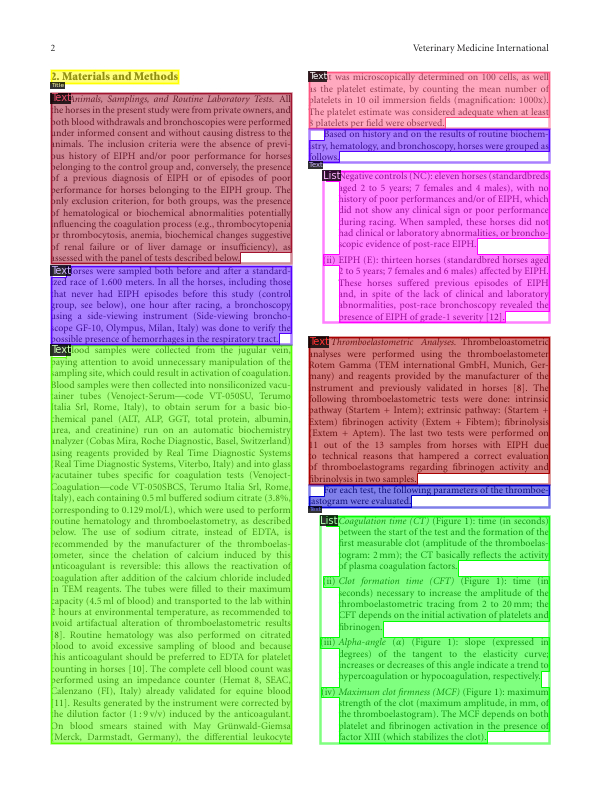

{'file_name': '/content/train/PMC3996933_00004.jpg', 'width': 601, 'id': 343576, 'height': 792, 'annotations': [{'segmentation': [[50.58, 500.98, 290.72, 500.98, 290.72, 514.42, 290.7, 514.42, 290.7, 523.71, 290.7, 523.71, 290.7, 537.15, 290.7, 537.15, 290.7, 548.52, 290.64, 548.52, 290.64, 557.82, 290.71, 557.82, 290.71, 571.25, 290.69, 571.25, 290.69, 582.62, 290.69, 582.62, 290.69, 592.42, 290.75, 592.42, 290.75, 605.86, 290.7, 605.86, 290.7, 617.72, 290.69, 617.72, 290.69, 629.4, 290.68, 629.4, 290.68, 638.69, 290.69, 638.69, 290.69, 652.13, 290.68, 652.13, 290.68, 661.43, 290.7, 661.43, 290.7, 674.86, 290.68, 674.86, 290.68, 684.16, 290.69, 684.16, 290.69, 697.6, 290.64, 697.6, 290.64, 706.89, 290.67, 706.89, 290.67, 718.26, 290.71, 718.26, 290.71, 731.7, 115.64, 731.7, 115.64, 743.07, 50.58, 743.07, 50.58, 729.63, 50.58, 718.26, 50.58, 706.89, 50.58, 695.53, 50.58, 684.16, 50.58, 672.79, 50.58, 661.43, 50.58, 650.06, 50.58, 638.69, 50.58, 638.69, 50.58, 627.32, 50.58, 627.32, 50.

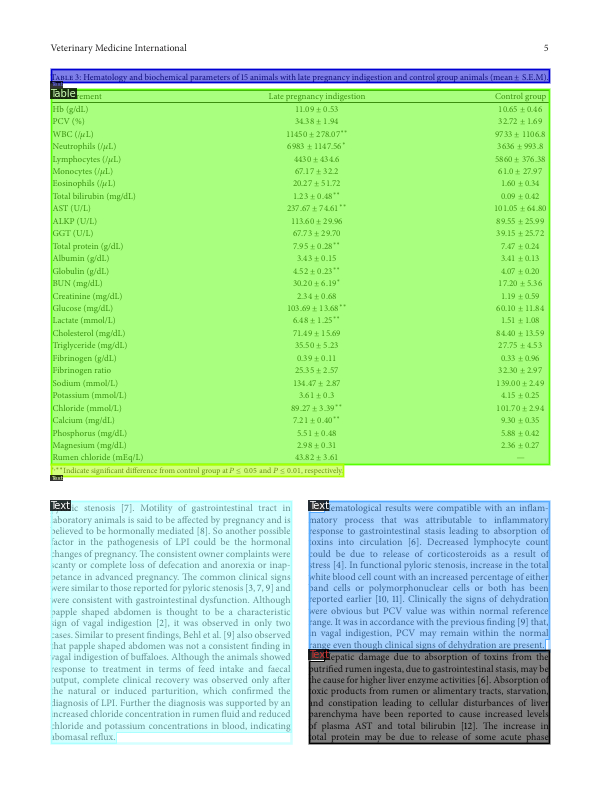

{'file_name': '/content/train/PMC4258245_00002.jpg', 'width': 610, 'id': 412078, 'height': 837, 'annotations': [{'segmentation': [[79.37, 107.66, 294.93, 107.66, 294.93, 119.76, 294.94, 119.76, 294.94, 135.13, 291.69, 135.13, 291.69, 143.95, 294.88, 143.95, 294.88, 156.05, 294.93, 156.05, 294.93, 171.43, 294.92, 171.43, 294.92, 183.52, 294.9, 183.52, 294.9, 195.62, 291.68, 195.62, 291.68, 204.44, 294.92, 204.44, 294.92, 219.82, 294.91, 219.82, 294.91, 231.92, 294.9, 231.92, 294.9, 240.74, 294.91, 240.74, 294.91, 256.11, 294.88, 256.11, 294.88, 264.93, 294.93, 264.93, 294.93, 280.31, 291.67, 280.31, 291.67, 289.13, 291.7, 289.13, 291.7, 301.23, 294.94, 301.23, 294.94, 316.6, 294.92, 316.6, 294.92, 325.42, 294.93, 325.42, 294.93, 340.8, 294.92, 340.8, 294.92, 352.89, 294.9, 352.89, 294.9, 364.99, 291.65, 364.99, 291.65, 377.09, 160.93, 377.09, 160.93, 389.19, 70.86, 389.19, 70.86, 373.81, 70.86, 361.71, 70.86, 349.62, 70.86, 337.52, 70.86, 325.42, 70.86, 313.32, 70.86, 301.23, 70.86, 289

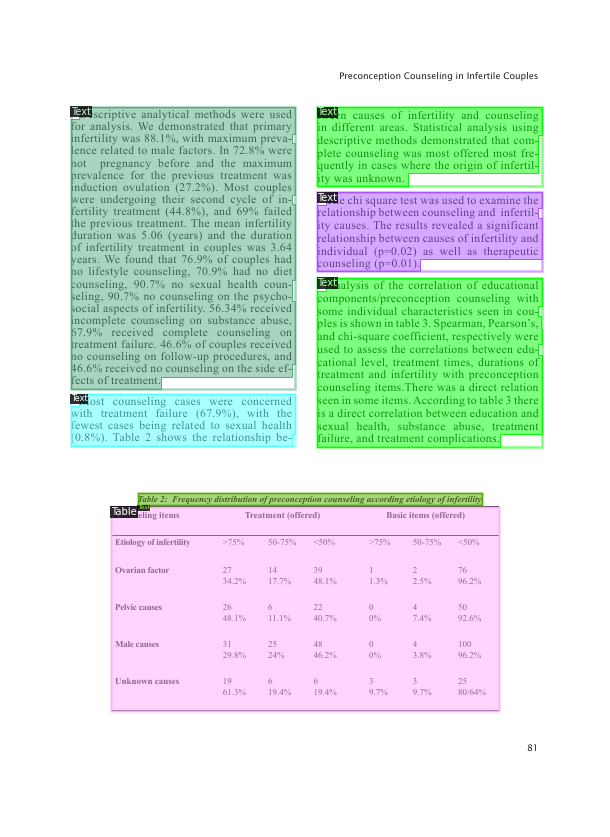

{'file_name': '/content/train/PMC6027194_00001.jpg', 'width': 596, 'id': 357501, 'height': 842, 'annotations': [{'segmentation': [[97.8, 88.55, 518.74, 88.55, 518.74, 102.06, 518.74, 102.06, 518.74, 115.57, 518.74, 115.57, 518.74, 127.79, 518.74, 127.79, 518.74, 141.3, 462.04, 141.3, 462.04, 154.81, 76.53, 154.81, 76.53, 141.3, 76.26, 141.3, 76.26, 129.08, 76.53, 129.08, 76.53, 114.28, 76.24, 114.28, 76.24, 102.06, 97.8, 102.06, 97.8, 88.55]], 'area': 28251.00585669611, 'iscrowd': 0, 'image_id': 357501, 'bbox': [76.24, 88.55, 442.51, 66.25], 'category_id': 0, 'id': 3481764, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'segmentation': [[97.8, 156.1, 518.74, 156.1, 518.74, 168.31, 518.74, 168.31, 518.74, 183.12, 520.48, 183.12, 520.48, 195.33, 518.74, 195.33, 518.74, 208.84, 518.74, 208.84, 518.74, 223.65, 519.99, 223.65, 519.99, 235.86, 518.74, 235.86, 518.74, 249.37, 518.74, 249.37, 518.74, 262.88, 518.74, 262.88, 518.74, 277.69, 518.74, 277.69, 518.74, 291.19, 518.74, 291.19, 518.74, 303.93,

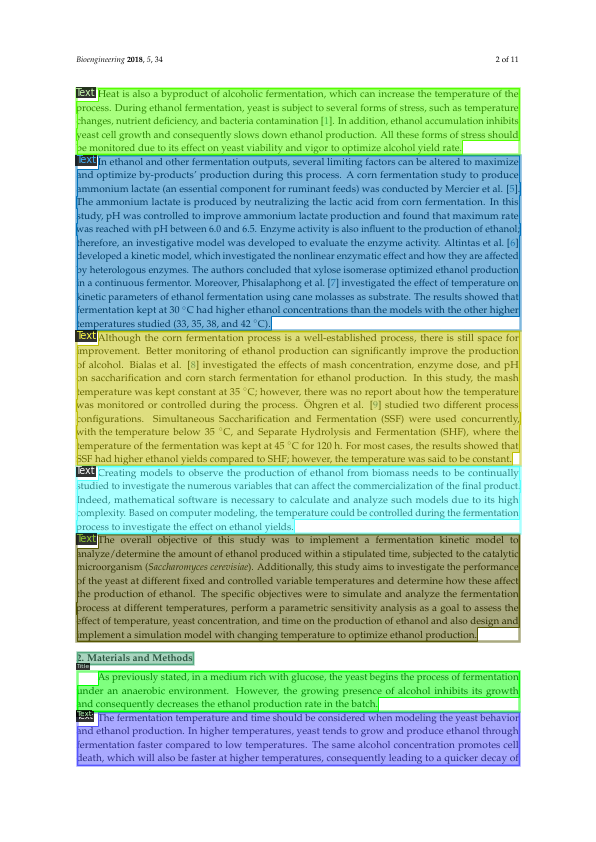

{'file_name': '/content/train/PMC5682257_00001.jpg', 'width': 596, 'id': 385613, 'height': 791, 'annotations': [{'segmentation': [[56.69, 86.7, 290.53, 86.7, 290.53, 98.92, 290.57, 98.92, 290.57, 109.83, 290.54, 109.83, 290.54, 121.85, 290.52, 121.85, 290.52, 134.92, 290.6, 134.92, 290.6, 145.83, 290.55, 145.83, 290.55, 157.85, 217.22, 157.85, 217.22, 169.87, 56.69, 169.87, 56.69, 158.95, 56.69, 146.94, 56.69, 134.92, 56.69, 122.95, 56.69, 110.94, 56.69, 98.92, 56.69, 98.92, 56.69, 86.7]], 'area': 18568.03342255595, 'iscrowd': 0, 'image_id': 385613, 'bbox': [56.69, 86.7, 233.91, 83.17], 'category_id': 0, 'id': 3764497, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'segmentation': [[64.69, 170.92, 290.49, 170.92, 290.49, 181.83, 290.46, 181.83, 290.46, 194.95, 290.52, 194.95, 290.52, 205.87, 290.49, 205.87, 290.49, 218.93, 290.55, 218.93, 290.55, 229.85, 290.52, 229.85, 290.52, 241.87, 290.49, 241.87, 290.49, 253.83, 288.63, 253.83, 288.63, 265.85, 56.69, 265.85, 56.69, 254.68, 56.69, 242.91, 5

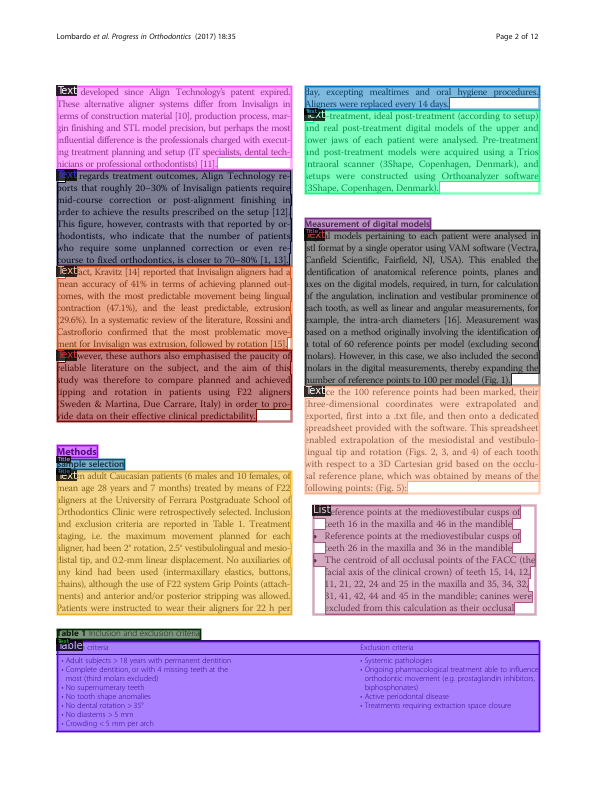

{'file_name': '/content/train/PMC5449357_00003.jpg', 'width': 596, 'id': 382821, 'height': 791, 'annotations': [{'segmentation': [[56.69, 512.97, 292.85, 512.97, 292.85, 531.79, 292.84, 531.79, 292.84, 539.66, 290.55, 539.66, 290.55, 549.13, 292.86, 549.13, 292.86, 563.67, 292.84, 563.67, 292.84, 575.66, 100.1, 575.66, 100.1, 591.78, 56.69, 591.78, 56.69, 572.83, 56.69, 561.13, 56.69, 549.13, 56.69, 537.12, 56.69, 525.13, 56.69, 512.97]], 'area': 15484.192212014808, 'iscrowd': 0, 'image_id': 382821, 'bbox': [56.69, 512.97, 236.16, 78.82], 'category_id': 0, 'id': 3734566, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'segmentation': [[312.73, 199.01, 540.9, 199.01, 540.9, 213.54, 538.58, 213.54, 538.58, 225.55, 361.11, 225.55, 361.11, 237.55, 304.72, 237.55, 304.72, 223.02, 304.73, 223.02, 304.73, 211.0, 312.73, 211.0, 312.73, 199.01]], 'area': 6821.063426386332, 'iscrowd': 0, 'image_id': 382821, 'bbox': [304.72, 199.01, 236.17, 38.54], 'category_id': 0, 'id': 3734567, 'bbox_mode': <BoxMode.XYW

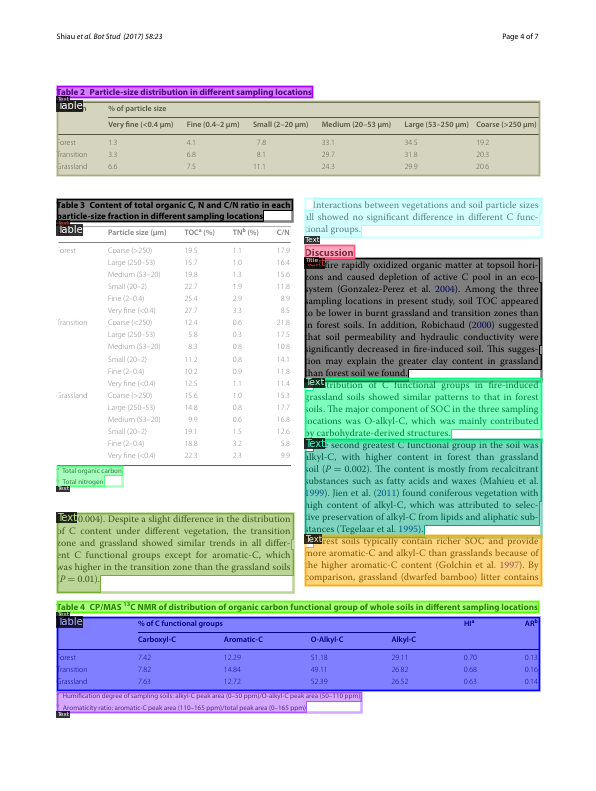

{'file_name': '/content/train/PMC4071641_00009.jpg', 'width': 612, 'id': 363995, 'height': 792, 'annotations': [{'segmentation': [[304.31, 394.4, 550.89, 394.4, 550.89, 405.86, 550.9, 405.86, 550.9, 417.31, 550.93, 417.31, 550.93, 427.36, 550.63, 427.36, 550.63, 438.82, 334.8, 438.82, 334.8, 450.28, 304.31, 450.28, 304.31, 440.23, 304.31, 428.77, 304.31, 417.31, 304.31, 405.86, 304.31, 394.4]], 'area': 11300.465636191657, 'iscrowd': 0, 'image_id': 363995, 'bbox': [304.31, 394.4, 246.62, 55.88], 'category_id': 0, 'id': 3543404, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'segmentation': [[46.35, 693.81, 292.95, 693.81, 292.95, 703.87, 292.93, 703.87, 292.93, 716.73, 292.98, 716.73, 292.98, 726.78, 46.35, 726.78, 46.35, 716.73, 46.35, 705.27, 46.35, 693.81]], 'area': 8129.099269580096, 'iscrowd': 0, 'image_id': 363995, 'bbox': [46.35, 693.81, 246.62, 32.96], 'category_id': 0, 'id': 3543405, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'segmentation': [[304.31, 475.36, 550.92, 475.36, 550.92, 486.82, 

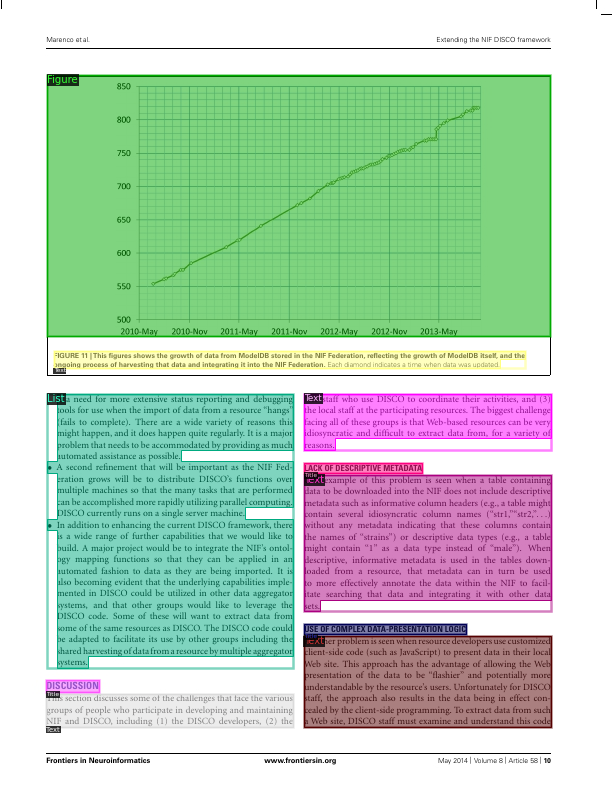

{'file_name': '/content/train/PMC5307876_00004.jpg', 'width': 596, 'id': 387739, 'height': 791, 'annotations': [{'segmentation': [[56.69, 422.92, 290.5, 422.92, 290.5, 434.93, 290.5, 434.93, 290.5, 445.85, 290.44, 445.85, 290.44, 458.91, 290.48, 458.91, 290.48, 470.66, 290.52, 470.66, 290.52, 481.84, 290.5, 481.84, 290.5, 494.89, 290.6, 494.89, 290.6, 505.83, 216.47, 505.83, 216.47, 517.84, 56.69, 517.84, 56.69, 506.92, 56.69, 494.89, 56.69, 482.94, 56.69, 470.66, 56.69, 458.91, 56.69, 446.95, 56.69, 434.93, 56.69, 422.92]], 'area': 21304.235934957163, 'iscrowd': 0, 'image_id': 387739, 'bbox': [56.69, 422.92, 233.91, 94.92], 'category_id': 0, 'id': 3784878, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'segmentation': [[64.69, 518.92, 290.5, 518.92, 290.5, 530.9, 290.54, 530.9, 290.54, 541.82, 290.48, 541.82, 290.48, 554.93, 290.55, 554.93, 290.55, 565.85, 290.52, 565.85, 290.52, 577.82, 290.52, 577.82, 290.52, 590.88, 290.53, 590.88, 290.53, 601.8, 290.51, 601.8, 290.51, 614.9, 290.53, 614.9,

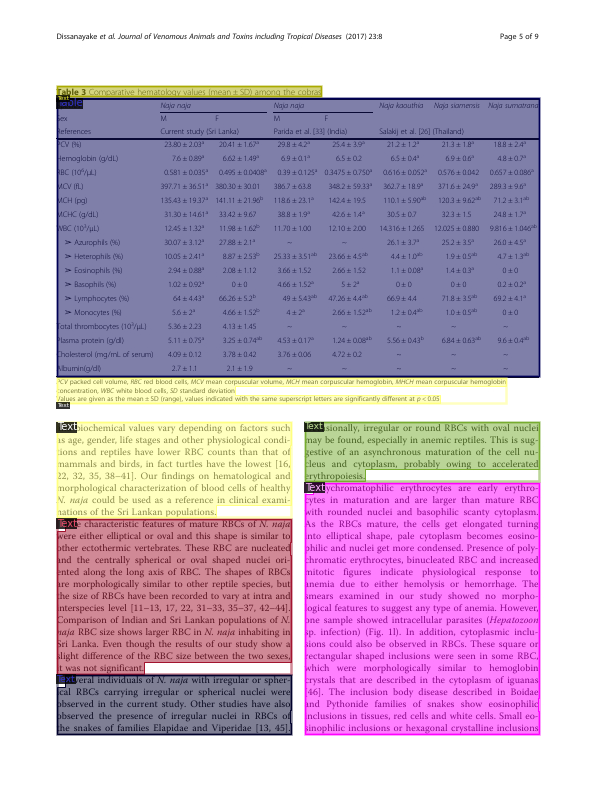

{'file_name': '/content/train/PMC4190019_00001.jpg', 'width': 601, 'id': 361527, 'height': 792, 'annotations': [{'segmentation': [[50.58, 70.14, 290.68, 70.14, 290.68, 81.51, 290.7, 81.51, 290.7, 92.87, 290.72, 92.87, 290.72, 106.31, 232.4, 106.31, 232.4, 117.68, 50.58, 117.68, 50.58, 104.24, 50.58, 92.87, 50.58, 81.51, 50.58, 70.14]], 'area': 10752.951468394458, 'iscrowd': 0, 'image_id': 361527, 'bbox': [50.58, 70.14, 240.14, 47.54], 'category_id': 0, 'id': 3516663, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'segmentation': [[50.58, 157.81, 290.68, 157.81, 290.68, 169.28, 290.72, 169.28, 290.72, 180.65, 290.74, 180.65, 290.74, 194.09, 290.71, 194.09, 290.71, 203.39, 290.71, 203.39, 290.71, 216.83, 290.68, 216.83, 290.68, 228.19, 84.74, 228.19, 84.74, 239.56, 50.58, 239.56, 50.58, 226.12, 50.58, 214.75, 50.58, 203.39, 50.58, 192.02, 50.58, 180.65, 50.58, 169.28, 50.58, 157.81]], 'area': 17288.636961249984, 'iscrowd': 0, 'image_id': 361527, 'bbox': [50.58, 157.81, 240.16, 81.75], 'category_i

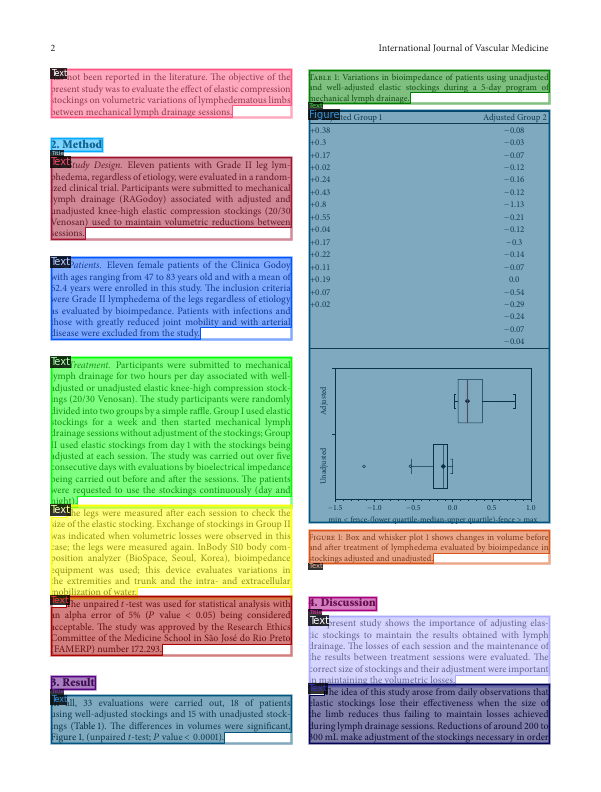

{'file_name': '/content/train/PMC3601529_00003.jpg', 'width': 596, 'id': 354699, 'height': 842, 'annotations': [{'segmentation': [[47.37, 762.0, 47.37, 552.51, 58.44, 552.51, 58.44, 762.0, 47.37, 762.0]], 'area': 2319.271934719698, 'iscrowd': 0, 'image_id': 354699, 'bbox': [47.37, 552.51, 11.07, 209.49], 'category_id': 0, 'id': 3454686, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'segmentation': [[63.68, 92.38, 551.38, 92.38, 551.38, 762.01, 63.68, 762.01, 63.68, 92.38]], 'area': 326576.90443548, 'iscrowd': 0, 'image_id': 354699, 'bbox': [63.68, 92.38, 487.7, 669.63], 'category_id': 3, 'id': 3454687, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}], 'image_id': 354699}
0
3


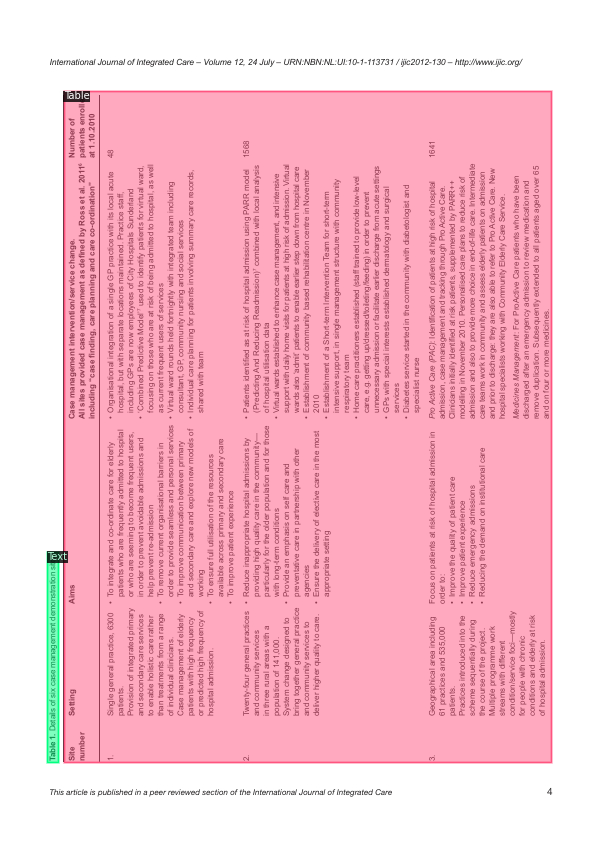

In [8]:
# #Visualizing the Train Dataset
# print(board_metadata)
board_metadata = MetadataCatalog.get("pubdal6_train")
print(board_metadata)
dataset_dicts = get_board_dicts("/content/train","train.json")
# # print(dataset_dicts)
# #Randomly choosing 3 images from the Set
for d in random.sample(dataset_dicts, 10):
    print(d)
    for i in d['annotations']:
      print(i['category_id'])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=board_metadata)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
text = 0
title = 0
_lis = 0
table = 0
figure = 0
for data in dataset_dicts:
  for i in data['annotations']:
    if i['category_id'] == 0:
      text += 1
    elif i['category_id'] == 1:
      title += 1
    elif i['category_id'] == 2:
      _lis += 1
    elif i['category_id'] == 3:
      table += 1
    else:
      figure += 1

In [9]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [69]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")) #Get the basic model configuration from the model zoo 
#Passing the Train and Validation sets
cfg.DATASETS.TRAIN = ("pubdal6_train",)
cfg.DATASETS.TEST = ("pubdal6_val",)
# Number of data loading threads
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
# Number of images per batch across all machines.
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0125  # pick a good LearningRate
cfg.SOLVER.MAX_ITER = 1500  #No. of iterations   
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5
cfg.TEST.EVAL_PERIOD = 500 # No. of iterations after which the Validation Set is evaluated. 
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = CocoTrainer(cfg) 
# trainer.resume_or_load(resume=False)
# trainer.train()

In [48]:
# !cp /content/drive/MyDrive/model_196000.pth /content/output

##Inference

{'instances': Instances(num_instances=10, image_height=794, image_width=610, fields=[pred_boxes: Boxes(tensor([[ 57.3132, 534.8917, 297.4850, 677.5903],
        [ 57.7333, 378.3565, 542.5236, 426.9042],
        [315.0578, 453.7692, 547.2316, 686.2495],
        [ 60.5141, 498.8302, 293.1732, 530.5610],
        [ 60.9071, 679.5237, 292.2026, 726.2136],
        [ 60.2473, 450.6819, 291.1873, 498.6254],
        [ 65.0173,  77.9497, 570.5050, 374.8643],
        [292.0889,  78.4197, 544.2093, 365.7834],
        [317.3033, 690.8696, 545.9406, 725.1205],
        [ 75.0856,  67.4495, 337.9282, 368.0084]], device='cuda:0')), scores: tensor([0.9968, 0.9964, 0.9933, 0.9875, 0.9872, 0.9815, 0.9661, 0.9646, 0.9645,
        0.8247], device='cuda:0'), pred_classes: tensor([0, 0, 0, 0, 0, 0, 4, 4, 0, 4], device='cuda:0')])}


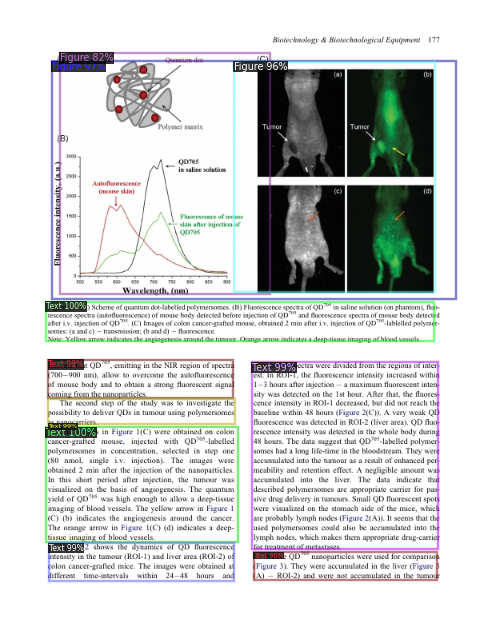

{'instances': Instances(num_instances=15, image_height=800, image_width=601, fields=[pred_boxes: Boxes(tensor([[ 90.5767, 658.0811, 293.3322, 710.6068],
        [ 47.9916,  69.3617, 292.4376, 182.9247],
        [323.6048, 644.6743, 552.8331, 743.4446],
        [ 47.7077, 187.2970, 291.9883, 453.1714],
        [ 93.7013, 563.4802, 293.4357, 631.7424],
        [362.6240, 195.5514, 547.1802, 244.8397],
        [ 70.3117, 515.6953, 292.2595, 639.3723],
        [325.0052, 263.1999, 548.3154, 570.9056],
        [331.5836,  66.3775, 549.2415, 250.4019],
        [ 65.7842, 527.6815, 291.3377, 559.5600],
        [348.1824,  70.3354, 545.8300, 105.1966],
        [311.4476, 258.0956, 478.3948, 268.9273],
        [348.8152, 578.2695, 549.3700, 617.4552],
        [324.1897, 142.6508, 550.0475, 182.5097],
        [ 68.9386, 640.6909, 282.9392, 651.9244]], device='cuda:0')), scores: tensor([0.9958, 0.9936, 0.9919, 0.9912, 0.9864, 0.9807, 0.9684, 0.9671, 0.9614,
        0.9599, 0.9295, 0.8378, 0.8363,

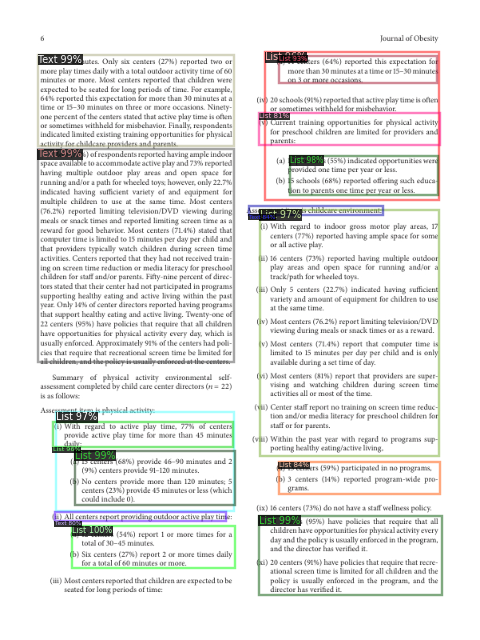

{'instances': Instances(num_instances=8, image_height=801, image_width=601, fields=[pred_boxes: Boxes(tensor([[ 48.3447, 676.9118, 290.2660, 748.9022],
        [310.5583, 678.5792, 543.7227, 723.3200],
        [ 53.3303, 652.1616, 237.8639, 661.9268],
        [115.8423, 362.4970, 484.8780, 374.5609],
        [ 54.7998, 379.9506, 564.1024, 648.9125],
        [313.1917, 725.6077, 541.1729, 746.3674],
        [207.8354, 329.6770, 389.1828, 340.8409],
        [ 64.5398,  58.8487, 559.8884, 324.6946]], device='cuda:0')), scores: tensor([0.9913, 0.9839, 0.9831, 0.9811, 0.9698, 0.9615, 0.8928, 0.8713],
       device='cuda:0'), pred_classes: tensor([0, 0, 0, 0, 3, 0, 0, 4], device='cuda:0')])}


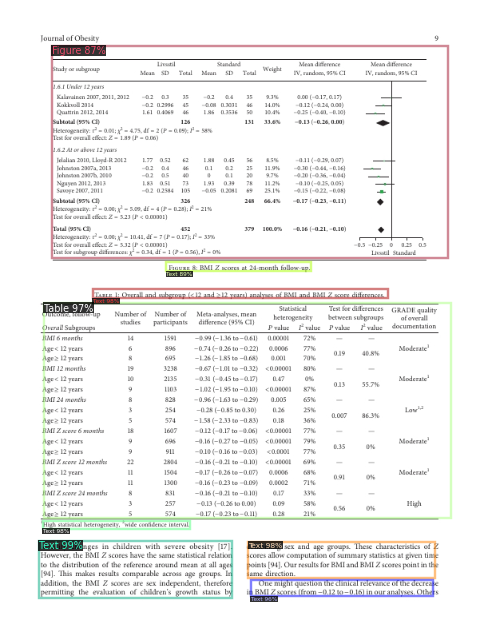

{'instances': Instances(num_instances=7, image_height=794, image_width=610, fields=[pred_boxes: Boxes(tensor([[ 59.2553, 377.3621, 289.4398, 509.3916],
        [ 67.4700, 534.0269, 294.5855, 699.7743],
        [ 60.3058,  69.6490, 550.8483, 335.9847],
        [316.8979, 417.8333, 548.2423, 731.1195],
        [ 62.8581, 704.7087, 294.0816, 734.2588],
        [ 61.9675, 340.0022, 550.6643, 358.5181],
        [319.0409, 379.6855, 550.7576, 413.7769]], device='cuda:0')), scores: tensor([0.9950, 0.9937, 0.9930, 0.9878, 0.9849, 0.9690, 0.9591],
       device='cuda:0'), pred_classes: tensor([0, 4, 4, 0, 0, 0, 0], device='cuda:0')])}


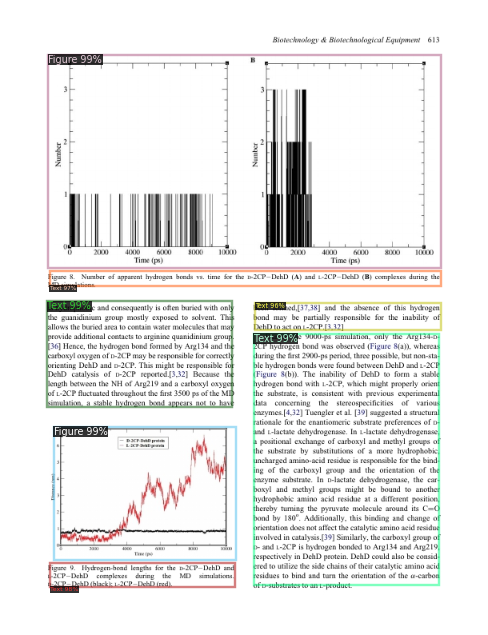

{'instances': Instances(num_instances=13, image_height=800, image_width=601, fields=[pred_boxes: Boxes(tensor([[ 50.2378, 427.0099, 289.2364, 542.2299],
        [ 49.1731, 286.3492, 289.9264, 414.3094],
        [ 51.1641, 162.7984, 286.1672, 252.0593],
        [308.9869, 583.7246, 543.7855, 740.2228],
        [ 52.2425,  77.8356, 291.3415, 163.0226],
        [312.0464, 266.9705, 548.3412, 510.9005],
        [308.5433, 173.2760, 546.2076, 249.6915],
        [ 50.4111, 556.1943, 289.8707, 623.5917],
        [308.4698,  72.4718, 546.1631, 138.2803],
        [311.7487, 515.3011, 550.1669, 572.8110],
        [ 51.7123, 268.8681, 179.3198, 281.8635],
        [309.7630, 153.9733, 400.0425, 164.5098],
        [ 82.1690, 652.3040, 292.5124, 741.6739]], device='cuda:0')), scores: tensor([0.9964, 0.9959, 0.9959, 0.9942, 0.9942, 0.9931, 0.9929, 0.9899, 0.9872,
        0.9810, 0.9653, 0.8911, 0.8109], device='cuda:0'), pred_classes: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')])

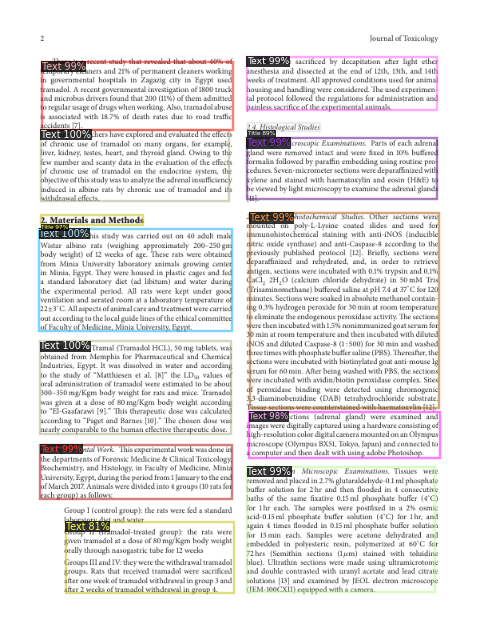

{'instances': Instances(num_instances=12, image_height=792, image_width=612, fields=[pred_boxes: Boxes(tensor([[ 49.8342, 702.6200, 564.6120, 735.2534],
        [223.1461, 200.2781, 388.9877, 314.3757],
        [ 48.0423, 417.4074, 383.2414, 450.3425],
        [397.0428, 294.8766, 566.5355, 454.0015],
        [399.8060,  85.3890, 564.9332, 291.2882],
        [ 43.5016, 342.8926, 388.1334, 414.9432],
        [ 42.1715, 461.4306, 564.0797, 473.1823],
        [223.0394,  66.0632, 389.4550, 200.5254],
        [ 55.2765, 323.4333, 382.5706, 340.9707],
        [ 49.5503,  66.7994, 211.3026, 311.8661],
        [ 63.8816, 482.5890, 548.6631, 698.6979],
        [399.1393,  65.4113, 564.9199,  84.5829]], device='cuda:0')), scores: tensor([0.9971, 0.9916, 0.9868, 0.9850, 0.9803, 0.9791, 0.9789, 0.9771, 0.9715,
        0.9622, 0.9568, 0.8877], device='cuda:0'), pred_classes: tensor([0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0], device='cuda:0')])}


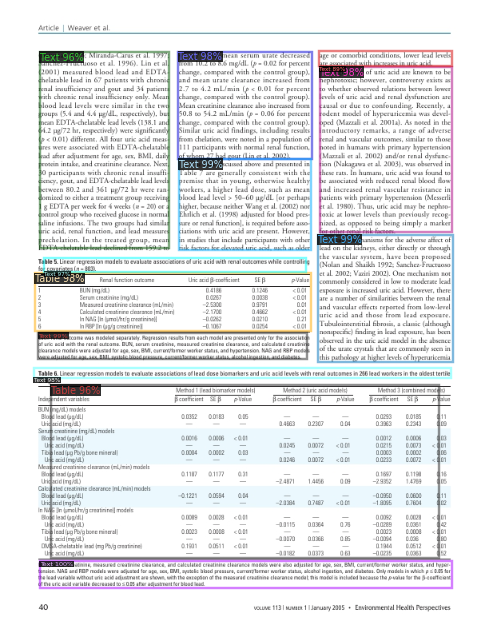

{'instances': Instances(num_instances=7, image_height=800, image_width=601, fields=[pred_boxes: Boxes(tensor([[312.9850, 516.2624, 547.5646, 735.9241],
        [ 52.7250, 545.9193, 292.9859, 743.4651],
        [ 57.7612, 425.1596, 549.2643, 470.2799],
        [307.9312, 492.2961, 550.1451, 514.9023],
        [245.5299,  71.5644, 354.8546,  81.7986],
        [ 49.8215, 492.7523, 293.4013, 551.9930],
        [ 53.4191,  88.3756, 548.2842, 411.7946]], device='cuda:0')), scores: tensor([0.9936, 0.9909, 0.9870, 0.9830, 0.9779, 0.9611, 0.8928],
       device='cuda:0'), pred_classes: tensor([0, 0, 0, 0, 0, 0, 3], device='cuda:0')])}


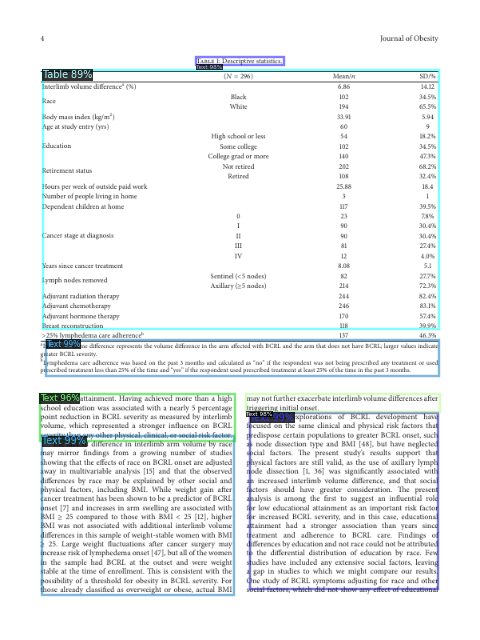

{'instances': Instances(num_instances=9, image_height=794, image_width=610, fields=[pred_boxes: Boxes(tensor([[315.8422, 583.0340, 553.6619, 727.0533],
        [315.0660, 451.4483, 552.7654, 580.1713],
        [314.5171, 267.0319, 551.9578, 453.3629],
        [316.2368,  68.3544, 545.7767, 230.1796],
        [ 57.6283,  94.8001, 296.4958, 307.6520],
        [ 60.1233, 342.9738, 295.2279, 722.1252],
        [317.6383, 256.9747, 448.5482, 267.8936],
        [ 61.8840, 328.5489, 214.0639, 340.1021],
        [ 61.5149,  69.0508, 295.8937,  90.6580]], device='cuda:0')), scores: tensor([0.9980, 0.9953, 0.9949, 0.9934, 0.9905, 0.9856, 0.9644, 0.9565, 0.9076],
       device='cuda:0'), pred_classes: tensor([0, 0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')])}


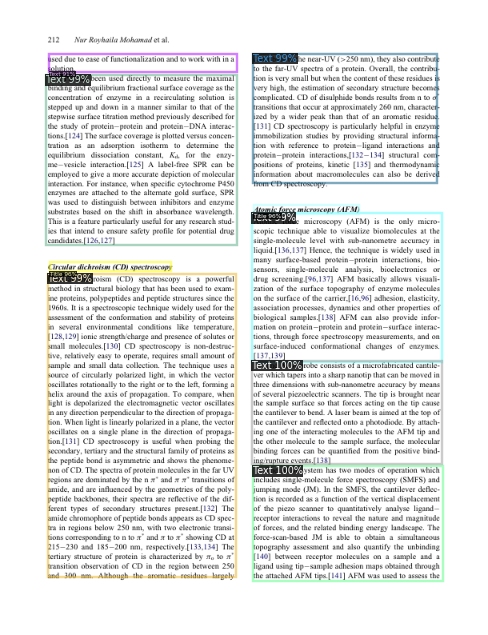

{'instances': Instances(num_instances=9, image_height=794, image_width=596, fields=[pred_boxes: Boxes(tensor([[312.3445, 641.5103, 552.4041, 725.4073],
        [309.2039, 483.2134, 555.8075, 639.5313],
        [ 55.5702, 571.3960, 296.8322, 634.1329],
        [ 57.5991, 668.1405, 296.3671, 727.9268],
        [ 57.8344, 490.1899, 295.6657, 571.3198],
        [ 68.0780, 435.2958, 529.7644, 468.0943],
        [ 56.3186, 646.0479, 127.4779, 659.0989],
        [ 67.4825, 211.3492, 578.7404, 433.8961],
        [227.0160,  63.1184, 398.3998, 225.2801]], device='cuda:0')), scores: tensor([0.9962, 0.9961, 0.9931, 0.9923, 0.9918, 0.9917, 0.9532, 0.9321, 0.9126],
       device='cuda:0'), pred_classes: tensor([0, 0, 0, 0, 0, 0, 1, 4, 4], device='cuda:0')])}


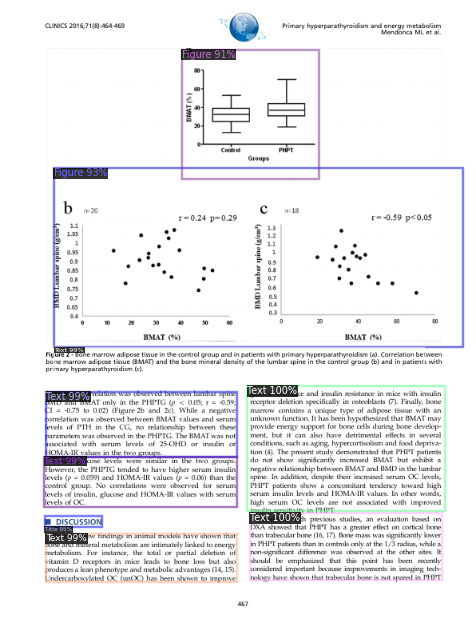

{'instances': Instances(num_instances=8, image_height=791, image_width=596, fields=[pred_boxes: Boxes(tensor([[ 59.6267,  86.3088, 382.2834,  97.1991],
        [ 51.7828, 280.5522, 291.9619, 523.9343],
        [304.9932, 305.5041, 537.0844, 527.5878],
        [ 66.5954, 717.4095, 340.1028, 727.6037],
        [ 63.9950, 557.1991, 542.3511, 716.0788],
        [ 56.5524, 254.3246, 225.4693, 262.2909],
        [305.3336, 278.5568, 536.1805, 300.2768],
        [ 67.4177,  98.2833, 538.6001, 251.3988]], device='cuda:0')), scores: tensor([0.9962, 0.9944, 0.9896, 0.9829, 0.9821, 0.9810, 0.9781, 0.9514],
       device='cuda:0'), pred_classes: tensor([0, 0, 0, 0, 4, 0, 0, 3], device='cuda:0')])}


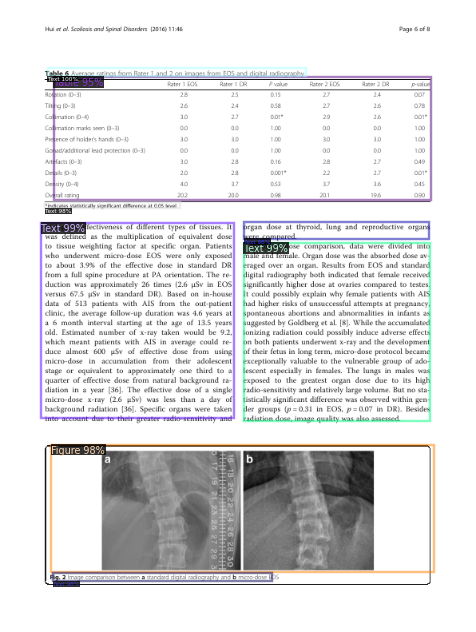

In [70]:
from detectron2.utils.visualizer import ColorMode

#Use the final weights generated after successful training for inference  
cfg.MODEL.WEIGHTS = "/content/output/model_final_frcnn.pth"

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # set the testing threshold for this model
#Pass the validation dataset
cfg.DATASETS.TEST = ("pubdal6_val", )

predictor = DefaultPredictor(cfg)

dataset_dicts = get_board_dicts("/content/val","val.json")
for d in random.sample(dataset_dicts, 10):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print(outputs)
    v = Visualizer(im[:, :, ::-1],
                   metadata=board_metadata, 
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE   
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu")) #Passing the predictions to CPU from the GPU
    cv2_imshow(v.get_image()[:, :, ::-1])

Evaluation

In [61]:
#import the COCO Evaluator to use the COCO Metrics
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
# for d in ["test"]:
#     DatasetCatalog.register("pubdal6_" + d, lambda d=d: get_board_dicts("/content/"+d,d + ".json"))
#     MetadataCatalog.get("pubdal6_" + d).set(thing_classes=["Text","Title","List","Table","Figure"])

#Call the COCO Evaluator function and pass the Validation Dataset
evaluator = COCOEvaluator("pubdal6_test", cfg, False, output_dir="/output/")
val_loader = build_detection_test_loader(cfg, "pubdal6_test")

#Use the created predicted model in the previous step
inference_on_dataset(predictor.model, val_loader, evaluator)

[05/10 14:30:39 d2.data.common]: Serializing 2249 elements to byte tensors and concatenating them all ...
[05/10 14:30:39 d2.data.common]: Serialized dataset takes 11.95 MiB
[05/10 14:30:39 d2.evaluation.evaluator]: Start inference on 2249 images
[05/10 14:30:40 d2.evaluation.evaluator]: Inference done 11/2249. 0.0606 s / img. ETA=0:02:17
[05/10 14:30:45 d2.evaluation.evaluator]: Inference done 93/2249. 0.0597 s / img. ETA=0:02:11
[05/10 14:30:50 d2.evaluation.evaluator]: Inference done 175/2249. 0.0598 s / img. ETA=0:02:06
[05/10 14:30:55 d2.evaluation.evaluator]: Inference done 255/2249. 0.0603 s / img. ETA=0:02:02
[05/10 14:31:00 d2.evaluation.evaluator]: Inference done 336/2249. 0.0603 s / img. ETA=0:01:58
[05/10 14:31:05 d2.evaluation.evaluator]: Inference done 416/2249. 0.0605 s / img. ETA=0:01:53
[05/10 14:31:10 d2.evaluation.evaluator]: Inference done 496/2249. 0.0607 s / img. ETA=0:01:48
[05/10 14:31:15 d2.evaluation.evaluator]: Inference done 575/2249. 0.0609 s / img. ETA=0:0

OrderedDict([('bbox',
              {'AP': nan,
               'AP50': nan,
               'AP75': nan,
               'APl': nan,
               'APm': nan,
               'APs': nan})])